In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

### 4. 基于统计学的时间序列分析方法
#### 4.1 自回归模型

<AxesSubplot:xlabel='date'>

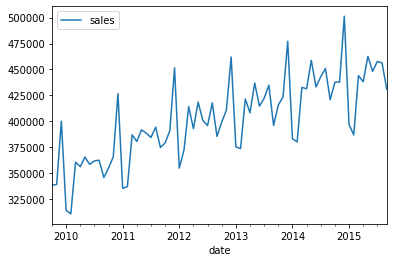

In [7]:
# 导入销售数据，绘制原始图像
sales_data = pd.read_csv('data/retail_sales.csv')
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)
sales_data.plot()

我们提到使用AR模型的两个前提假设，相关性和平稳性。
因此先来检验相关性。

检验相关性有两种方法
- pandas提供了autocorrelation_plot方法用于检验整体自相关性
- 使用pandas的lag_plot方法检查单个时间间隔的相关性

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

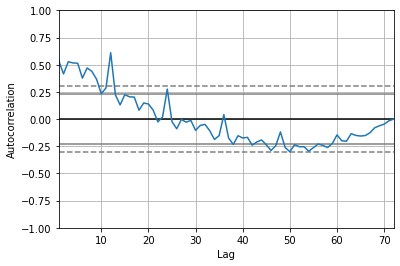

In [14]:
pd.plotting.autocorrelation_plot(sales_data['sales']) 
# 从自相关性图中可以看到在lag<=12时，acf值在临界点以外，表现出极强的相关性。

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

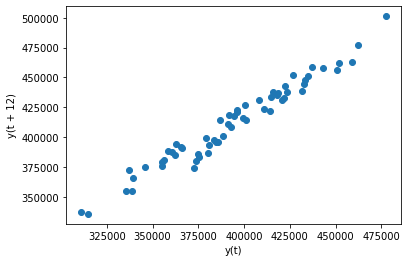

In [15]:
# 将上图中相关性最强的lag=12单独画散点图，观察相关性
pd.plotting.lag_plot(sales_data['sales'],lag=12)

第二步检查平稳性，一个最快捷的方法之一是使用statsmodels中的seasonal_decompose方法进行趋势项和季节项的分解。

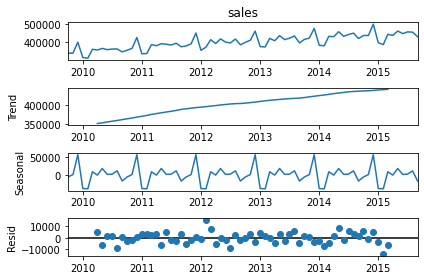

In [68]:
# 数据集存在明显趋势项（图二单调递增）和季节项（图三周期性变化）
decomposed = seasonal_decompose(sales_data['sales'], model='additive')
x = decomposed.plot()

幸好statsmodel包的AutoReg方法增加了对趋势和季节项特征的处理，直接使用该方法即可

In [106]:
# 划分训练集合测试集
X = sales_data['sales']
train_data = X[1:len(X)-12]
test_data = X[len(X)-12:]  #以最后十二个点作为待预测值

# 训练AR模型
model = AutoReg(train_data,lags=15,missing='drop',trend='t',seasonal=True) 
model_fitted = model.fit()

c:\users\skywater\pycharmprojects\personal\py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\skywater\pycharmprojects\personal\py39\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [112]:
# 查看模型结果
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   59
Model:              Seas. AutoReg(15)   Log Likelihood                -422.998
Method:               Conditional MLE   S.D. of innovations           3621.518
Date:                Tue, 22 Jun 2021   AIC                             17.707
Time:                        22:47:53   BIC                             18.883
Sample:                    02-01-2011   HQIC                            18.144
                         - 09-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
trend         839.9681    362.378      2.318      0.020     129.721    1550.216
seasonal.0   2.213e+05   8.34e+04      2.653      0.008    5.78e+04    3.85e+05
seasonal.1   2.808e+05   8.08e+04      3.476      0.001    1.22e+05    4.39e+05
seasonal.2   1.924e+05    8.7e+04      2.212      0.027    2.19e+04    3.63e+05
seasonal.3   1.689e+05   8.69e+04      1.945      0.052   -1331.228    3.39e+05
seasonal.4   2.263e+05   8.29e+04      2.728      0.006    6.37e+04    3.89e+05
seasonal.5   2.335e+05   7.98e+04      2.926      0.003    7.71e+04     3.9e+05
seasonal.6    2.09e+05   8.26e+04      2.530      0.011    4.71e+04    3.71e+05
seasonal.7   2.318e+05   8.32e+04      2.785      0.005    6.87e+04    3.95e+05
seasonal.8    2.33e+05   8.41e+04      2.771      0.006    6.82e+04    3.98e+05
seasonal.9   2.224e+05    8.4e+04      2.648      0.008    5.78e+04    3.87e+05
seasonal.10  1.901e+05   8.46e+04      2.246      0.025    2.42e+04    3.56e+05
seasonal.11  2.123e+05   8.59e+04      2.473      0.013     4.4e+04    3.81e+05
sales.L1        0.2604      0.155      1.685      0.092      -0.042       0.563
sales.L2        0.1237      0.158      0.785      0.433      -0.185       0.433
sales.L3        0.0379      0.150      0.252      0.801      -0.256       0.332
sales.L4       -0.2515      0.149     -1.691      0.091      -0.543       0.040
sales.L5        0.2431      0.163      1.496      0.135      -0.075       0.562
sales.L6       -0.1179      0.163     -0.722      0.470      -0.438       0.202
sales.L7       -0.1311      0.164     -0.799      0.424      -0.453       0.190
sales.L8       -0.0212      0.196     -0.108      0.914      -0.406       0.363
sales.L9        0.2763      0.201      1.374      0.169      -0.118       0.670
sales.L10       0.0443      0.200      0.222      0.825      -0.347       0.436
sales.L11       0.1980      0.203      0.975      0.330      -0.200       0.596
sales.L12       0.1034      0.202      0.512      0.609      -0.292       0.499
sales.L13      -0.4173      0.206     -2.029      0.042      -0.820      -0.014
sales.L14       0.0320      0.192      0.166      0.868      -0.345       0.409
sales.L15       0.0085      0.206      0.041      0.967      -0.396       0.413
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.9178           -0.4910j            1.0409           -0.4218
AR.2            -0.9178           +0.4910j            1.0409            0.4218
AR.3            -1.1752           -0.0000j            1.1752           -0.5000
AR.4            -0.6070           -0.8247j            1.0241           -0.3510
AR.5            -0.6070           +0.8247j            1.0241            0.3510
AR.6            -0.0849           -1.1181j        

c:\users\skywater\pycharmprojects\personal\py39\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


<AxesSubplot:>

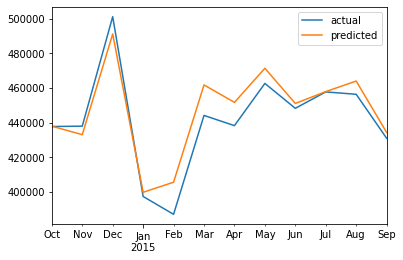

In [110]:
# 预测测试集
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)  # dynamic参数表示是否用预测值动态预测下一个时刻的值

# 比较真实值和预测值
compare_df = pd.concat(
    [sales_data['sales'].tail(12),
    predictions], axis=1).rename(
    columns={'sales': 'actual', 0:'predicted'})
compare_df.plot()

#### 4.2 移动平均模型

##### 模拟MA序列

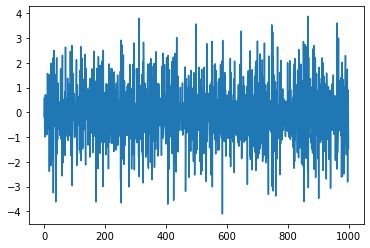

In [6]:
# ar,ma必须以array的形式输入，且第一位表示lag=0，通常这个值会设为1
ar = np.array([1])  # ar项只有一个间隔=0的值表示是一个纯MA序列
ma = np.array([1, -0.9]) # ma序列有两个值，第一个是常数项，第二个是前一个时刻的系数，这是一个MA(1)模型
MA_object = ArmaProcess(ar, ma)
simulated_data = MA_object.generate_sample(nsample=1000)
plt.plot(simulated_data)

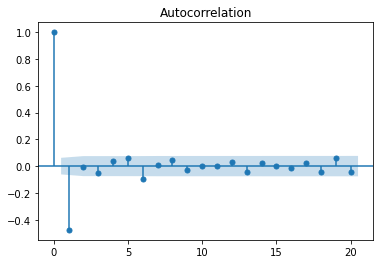

In [11]:
# 画出acf图像后看到，如上文所说，对于一个MA(1)序列，从时间间隔大于等于2开始，相关系数断崖式下降
plot_acf(simulated_data, lags=20)
plt.show()

##### 模型拟合与评估

In [22]:
# order=(0,1)表示这是一个纯MA(1)模型
mod = ARMA(simulated_data_1, order=(0, 1))  
res = mod.fit()

# 观察模型拟合结果， 系数为-0.8937，和我们创建时间序列的系数-0.9很接近
print(res.summary())

# 打印拟合值
print(res.params)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1442.463
Method:                       css-mle   S.D. of innovations              1.023
Date:                Wed, 23 Jun 2021   AIC                           2890.927
Time:                        20:46:29   BIC                           2905.650
Sample:                             0   HQIC                          2896.523
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.003     -0.175      0.861      -0.007       0.006
ma.L1.y       -0.8937      0.016    -57.081      0.000      -0.924      -0.863
                                    Roots           

c:\users\skywater\pycharmprojects\personal\py39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


##### 模型预测

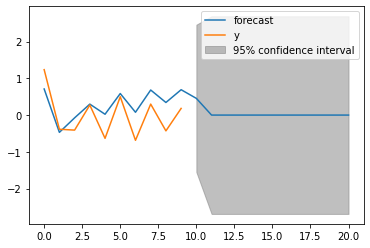

In [26]:
res.plot_predict(start=990, end=1010)
plt.show()

可以看到MA模型仅仅对样本内的值有实际预测效果，对样本外的值会用统一用整体均值来预测

#### 4.3 ARIMA模型

**手动拟合法**

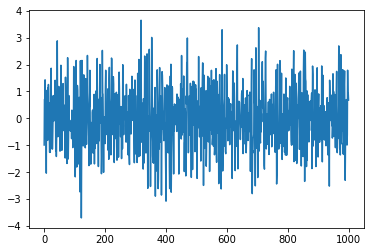

In [35]:
# 模拟ARMA数据，在完成最终拟合前，请假装不知道样本时间序列的参数
import statsmodels.api as sm
ar = np.array([1,-0.8, 0.4])  
ma = np.array([1,-0.7]) 
arma_process = sm.tsa.ArmaProcess(ar, ma)
y = arma_process.generate_sample(1000)
plt.plot(y)

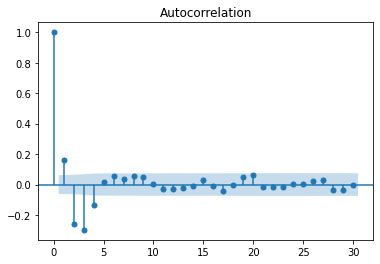

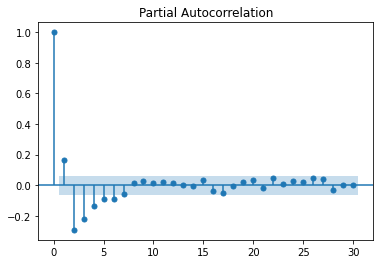

In [41]:
# step1 - 画出acf，pacf曲线，根据经验规则，没有明显的cutoff，模型应当包含AR和MA项
plot_acf(y)
plot_pacf(y)
plt.show()

In [46]:
# step2，用最简单的arima(1,0,1)尝试拟合
mod = ARIMA(y, order=(1,0,1))  
res = mod.fit()

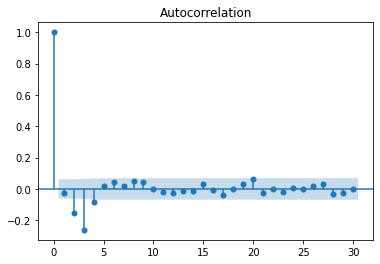

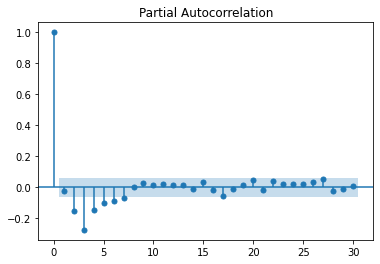

In [54]:
# step3，画出拟合残差的acf和pacf
plot_acf(res.resid)
plot_pacf(res.resid)
plt.show()

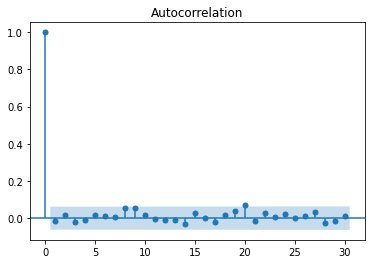

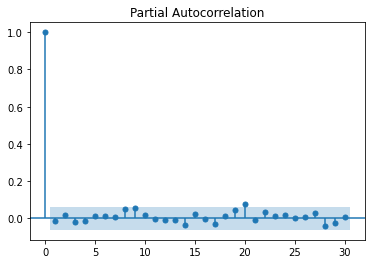

In [58]:
# step4，从上面对residual绘制acf和pacf可以看到，还存在有显著的自相关性，说明最开始尝试的ARIMA(1,0,1)模型并没有充分表达原数据  
# 尝试增加模型复杂度
a2m1 = ARIMA(y, order=(2,0,1)).fit()  
plot_acf(a2m1.resid)
plot_pacf(a2m1.resid)
plt.show()

In [76]:
# step5，通过将AR项从一阶改成二阶，这个更复杂的模型取得了不错的效果，残差的acf和pacf几乎看不到其他相关性存在  
# 为了验证是否还能获得更好的模型，继续修改参数进行测试，一个简单快速的验证方式是计算真实值和预测值的相关系数
def model_performance(p,d,q):
    model = ARIMA(y, order=(p,d,q)).fit()  
    df = pd.DataFrame({'predict':model.predict(),'true':y})
    corr = df.corr().loc['predict','true']
    print("ARIMA({0},{1},{2}) performance: {3} ".format(p,d,q,corr))

In [78]:
model_performance(1,0,1)
model_performance(2,0,1)
model_performance(1,0,2)
model_performance(2,0,2)
model_performance(2,1,2)

ARIMA(1,0,1) performance: 0.23256695743385164 
ARIMA(2,0,1) performance: 0.42499463153273376 
ARIMA(1,0,2) performance: 0.39161778792506313 
ARIMA(2,0,2) performance: 0.42705219696176494 
ARIMA(2,1,2) performance: 0.4152659567936595 


c:\users\skywater\pycharmprojects\personal\py39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


可以看到ARIMA(2,0,1)的效果有了明显提升，而当再增加模型复杂度时，效果没有明显提升。当然这只是一个极为粗略的手动拟合的例子，真实场景则需要更为精细的优化。

In [87]:
ARIMA(y, order=(2,0,1)).fit().params # 模型系数 ar1=0.79,ar2=-0.4,ma1=-0.69和最开始我们创建的时间序列系数很接近，获得了不错的拟合效果

array([ 0.00219359,  0.78972449, -0.40471765, -0.68275666,  0.97684689])

**自动拟合法**

<AxesSubplot:xlabel='date'>

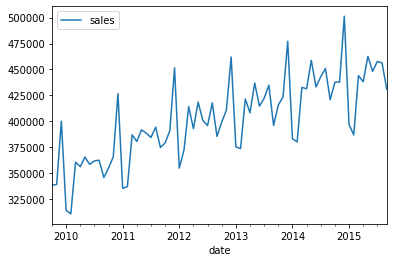

In [94]:
# step1，准备数据
sales_data = pd.read_csv('data/retail_sales.csv')
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)
sales_data.plot()

In [96]:
# step2，检查平稳性
adf_test = ADFTest()
adf_test.should_diff(sales_data) #结果表明不平稳，提示我们需要引入差分项

(0.01, False)

In [98]:
# step3，划分训练集和测试集
train = sales_data[:60]
test = sales_data[60:]

In [100]:
# step4，拟合模型
arima_model = auto_arima(train, start_p=0, d=1,start_q=0, max_p=5,max_d=5,max_q=5,
                         start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,trace=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=981.377, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=982.734, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=982.307, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=983.595, Time=0.13 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1005.088, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1007.898, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=981.328, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=982.703, Time=0.13 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=984.307, Time=0.68 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=987.645, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=982.083, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=980.880, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=982.336, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=983.925, Time=0.46 sec
 ARIMA(0,1,2)(0,1,0)[12]       

In [101]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -488.440
Date:                             Tue, 29 Jun 2021   AIC                            980.880
Time:                                     17:09:46   BIC                            984.580
Sample:                                          0   HQIC                           982.272
                                              - 60                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0445      0.035     -1.257      0.209      -0.114       0.025
sigma2      5.112e+07   2.95e-11   1.73e+18      0.000    5.11e+07    5.11e+07
===================================================================================
Ljung-Box (L1) (Q):                  11.29   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.00   Prob(JB):                         0.82
Heteroskedasticity (H):               1.28   Skew:                            -0.05
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.66e+33. Standard errors may be unstable.
"""

In [124]:
# step5，预测时间序列，并和真实值比较
pred = pd.DataFrame(arima_model.predict(n_periods=12),columns=['predicted'],index=test.index)

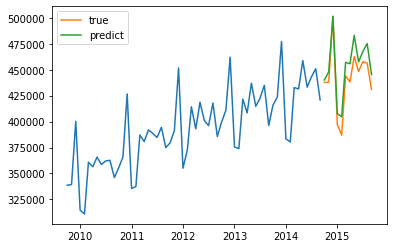

In [123]:
plt.plot(train)
plt.plot(test,label='true')
plt.plot(pred,label='predict')
plt.legend();